<a href="https://colab.research.google.com/github/PaulYogesh/Mic-hackathon-2025/blob/main/NN_based_SEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ===============================================================
# 0. Install dependencies (if needed)
# ===============================================================
# !pip install scikit-image tensorflow matplotlib
#!pip install -q segmentation-models
#!pip install tensorflow-advanced-segmentation-models
#!pip install -q keras-cv
!pip install -q keras-hub


In [2]:

# ===============================================================
# 1. Imports
# ===============================================================
#import keras_cv
from google.colab import files
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import keras_hub
import cv2
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.models import Model

from skimage import measure, morphology, filters
np.random.seed(0)
tf.random.set_seed(0)


Saving 10 um.png to 10 um.png


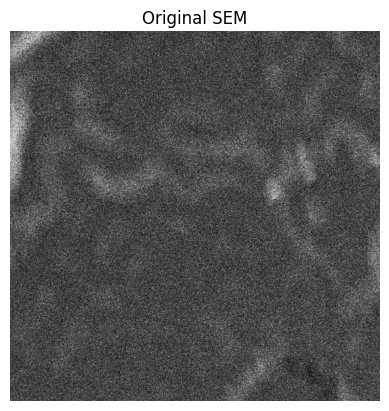

In [3]:
# ===============================================================
# 2. Upload SEM image (same as before)
# ===============================================================

uploaded = files.upload()
fname = next(iter(uploaded))

img = Image.open(fname).convert("L")
sem_image = np.array(img)

H, W = sem_image.shape

plt.imshow(sem_image, cmap="gray")
plt.title("Original SEM")
plt.axis("off")
plt.show()


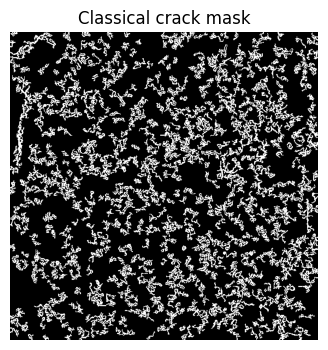

In [4]:
# ===============================================================
# 3. Classical segmentation (for labels + baseline metrics)
# ===============================================================
def classical_crack_segmentation(sem_image):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_img = clahe.apply(sem_image)

    gauss = cv2.GaussianBlur(clahe_img, (5, 5), 0)

    sobelx = cv2.Sobel(gauss, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(gauss, cv2.CV_64F, 0, 1, ksize=3)
    sobel_mag = np.sqrt(sobelx**2 + sobely**2)

    sobel_norm = cv2.normalize(
        sobel_mag, None, alpha=0, beta=1,
        norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F
    )

    sobel_uint8 = (sobel_norm * 255).astype(np.uint8)
    _, binary = cv2.threshold(
        sobel_uint8, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    crack_mask = binary > 0
    cleaned = morphology.remove_small_objects(crack_mask, min_size=50)

    return cleaned.astype(bool)

binary_classical = classical_crack_segmentation(sem_image)

plt.figure(figsize=(4,4))
plt.imshow(binary_classical, cmap="gray")
plt.axis("off")
plt.title("Classical crack mask")
plt.show()

In [5]:
# ===============================================================
# 4. Crack metrics (shared for classical & NN)
# ===============================================================
def compute_crack_metrics(binary_mask, FOV_um):
    binary_mask = binary_mask.astype(bool)

    Hm, Wm = binary_mask.shape
    T_P = Wm * Hm
    pixel_size = FOV_um / Wm  # µm/pixel

    labeled, N_C = measure.label(binary_mask, connectivity=2, return_num=True)
    regions = measure.regionprops(labeled)

    L_px = sum(r.perimeter for r in regions)
    L_um = L_px * pixel_size

    A_px = sum(r.area for r in regions)
    A_um2 = A_px * (pixel_size ** 2)

    C_px   = N_C / T_P
    C_um2  = N_C / (FOV_um ** 2)
    C_px_s = N_C / A_px if A_px > 0 else 0.0
    C_um2s = N_C / A_um2 if A_um2 > 0 else 0.0

    print(f"Field of view (FOV): {FOV_um:.1f} µm")
    print(f"Pixel size: 0.0301 µm/pixel (fixed from FOV/width)")
    print(f"Number of microcracks (N_C): {N_C}")
    print(f"Total crack length (L_px): {L_px:.2f} pixels")
    print(f"Total crack length (L_µm): {L_um:.2f} µm")
    print(f"Total cracked area (A_px): {A_px:.2f} pixels")
    print(f"Total cracked area (A_µm²): {A_um2:.2f} µm²")
    print(f"Crack density per pixel (C_px): {C_px:.6e} pixel⁻¹")
    print(f"Crack density per unit area (C_µm⁻²): {C_um2:.6e} µm⁻²")
    print(f"Crack count per cracked pixel area (C*_px): {C_px_s:.6e}")
    print(f"Crack count per cracked area (C*_µm⁻²): {C_um2s:.6e}")

    return {
        "N_C": N_C,
        "L_px": L_px, "L_um": L_um,
        "A_px": A_px, "A_um2": A_um2,
        "C_px": C_px, "C_um2": C_um2,
        "C_px_star": C_px_s, "C_um2_star": C_um2s,
        "mask": binary_mask,
    }

FOV_UM = 20.0  # same as before

print("\n===== Classical metrics =====")
metrics_classical = compute_crack_metrics(binary_classical, FOV_UM)




===== Classical metrics =====
Field of view (FOV): 20.0 µm
Pixel size: 0.0301 µm/pixel (fixed from FOV/width)
Number of microcracks (N_C): 367
Total crack length (L_px): 50881.95 pixels
Total crack length (L_µm): 1804.32 µm
Total cracked area (A_px): 67764.00 pixels
Total cracked area (A_µm²): 85.21 µm²
Crack density per pixel (C_px): 1.153740e-03 pixel⁻¹
Crack density per unit area (C_µm⁻²): 9.175000e-01 µm⁻²
Crack count per cracked pixel area (C*_px): 5.415855e-03
Crack count per cracked area (C*_µm⁻²): 4.306905e+00


In [6]:
# ===============================================================
# 5. Pad image & mask to multiples of 16 for U-Net
# ===============================================================
H2 = ((H + 15) // 16) * 16
W2 = ((W + 15) // 16) * 16

pad_H = H2 - H
pad_W = W2 - W

sem_pad = np.pad(sem_image, ((0, pad_H), (0, pad_W)), mode="edge")
mask_pad = np.pad(binary_classical, ((0, pad_H), (0, pad_W)), mode="edge")




In [7]:
# @title 3rd iteration: Prepare tensors (3‑channel for ResNet)
X = sem_pad.astype(np.float32) / 255.0
X = np.stack([X, X, X], axis=-1)   # grayscale → RGB
y = mask_pad.astype(np.float32)[..., None]

X = X[None, ...]
y = y[None, ...]

print("Training shapes:", X.shape, y.shape)


Training shapes: (1, 576, 576, 3) (1, 576, 576, 1)


In [8]:
# @title KerasCV ResNet18 encoder (Phase 1)
encoder = keras_hub.models.ResNetBackbone.from_preset(
    "resnet_18_imagenet",
    input_shape=(H2, W2, 3)
)

# Freeze encoder initially
encoder.trainable = False


Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.9191
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 0.9009
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.8868
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.8769
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.8710
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.8686
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.8688
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.8703
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.8719
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.8729
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.8730
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.8721
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.8707
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.8688
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.8669
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.8652

In [9]:
# @title Extract multi‑scale features (skip connections)
s1 = encoder.get_layer("stack0_block1_out").output   # /4
s2 = encoder.get_layer("stack1_block1_out").output   # /8
s3 = encoder.get_layer("stack2_block1_out").output   # /16
b  = encoder.get_layer("stack3_block1_out").output   # /32

In [10]:

def conv_block(x, filters):
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = tf.keras.layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    return x

x = tf.keras.layers.UpSampling2D()(b)
x = tf.keras.layers.Concatenate()([x, s3])
x = conv_block(x, 256)

x = tf.keras.layers.UpSampling2D()(x)
x = tf.keras.layers.Concatenate()([x, s2])
x = conv_block(x, 128)

x = tf.keras.layers.UpSampling2D()(x)
x = tf.keras.layers.Concatenate()([x, s1])
x = conv_block(x, 64)

x = tf.keras.layers.UpSampling2D()(x) # Upsample from /4 to /2
x = tf.keras.layers.UpSampling2D()(x) # Upsample from /2 to original (H2, W2)
outputs = tf.keras.layers.Conv2D(1, 1, activation="sigmoid")(x)

model = Model(encoder.input, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None,      │          0 │ -                 │
│ (InputLayer)        │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, None,      │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, None,      │      9,408 │ conv1_pad[0][0]   │
│                     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, None,      │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, None,      │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, None,      │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, None,      │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_1_co… │ (None, None,      │     36,864 │ pool1_pool[0][0]  │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_1_bn  │ (None, None,      │        256 │ stack0_block0_1_… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_1_re… │ (None, None,      │          0 │ stack0_block0_1_… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_2_co… │ (None, None,      │     36,864 │ stack0_block0_1_… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_2_bn  │ (None, None,      │        256 │ stack0_block0_2_… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_add   │ (None, None,      │          0 │ pool1_pool[0][0], │
│ (Add)               │ None, 64)         │            │ stack0_block0_2_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block0_out   │ (None, None,      │          0 │ stack0_block0_ad… │
│ (Activation)        │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block1_1_co… │ (None, None,      │     36,864 │ stack0_block0_ou… │
│ (Conv2D)            │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block1_1_bn  │ (None, None,      │        256 │ stack0_block1_1_… │
│ (BatchNormalizatio… │ None, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack0_block1_1_re… │ (None, None,      │          0 │ stack0_block1_1_

 Total params: 14,283,649 (54.49 MB)

 Trainable params: 3,097,537 (11.82 MB)

 Non-trainable params: 11,186,112 (42.67 MB)

In [11]:
# @title Loss (BCE + Dice)
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    inter = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2*inter + smooth) / (
        tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth
    )

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),
    loss=lambda yt, yp:
        tf.keras.losses.binary_crossentropy(yt, yp) + dice_loss(yt, yp)
)


In [12]:
# @title New: Loss refinement (thin‑structure bias)
def focal_loss(y_true, y_pred, gamma=2.0):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    p_t = tf.exp(-bce)
    return tf.reduce_mean((1 - p_t)**gamma * bce)

def combined_loss(y_true, y_pred):
    return focal_loss(y_true, y_pred) + dice_loss(y_true, y_pred)


In [13]:
# @title Train (prototype)
model.fit(X, y, epochs=30, verbose=1)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - loss: 1.5131
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.4721
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.4355
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.4035
Epoch 5/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.3763
Epoch 6/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.3540
Epoch 7/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.3362
Epoch 8/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.3228
Epoch 9/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.3133
Epoch 10/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.3075
Epoch 11/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.3047
Epoch 12/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.3042
Epoch 13/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.3052
Epoch 14/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 1.3069
Epoch 15/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 1.3086
Epoch 16/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 1.3099
E

In [14]:
# @title Predict + threshold
pred = model.predict(X)[0, ..., 0]
thr = filters.threshold_otsu(pred)
binary_nn = (pred > thr)[:H, :W]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [24]:
# @title PHASE 2: Unfreeze last ResNet block (currently testing)

# -------- PHASE 2: Unfreeze last ResNet block --------
for layer in encoder.layers:
    if "stack3" in layer.name:   # LAST ResNet stage only
        layer.trainable = True

# IMPORTANT: recompile with lower LR
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # LOWER LR
    loss=combined_loss
)

# Fine-tuning
model.fit(X, y, epochs=20, verbose=1)

Epoch 1/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step - loss: 0.8619
Epoch 2/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.8609
Epoch 3/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.8603
Epoch 4/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.8592
Epoch 5/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.8582
Epoch 6/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.8575
Epoch 7/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.8567
Epoch 8/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.8558
Epoch 9/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.8548
Epoch 10/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.8539
Epoch 11/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step - loss: 0.8531
Epoch 12/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.8523
Epoch 13/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.8514
Epoch 14/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.8506
Epoch 15/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.8498
Epoch 16/20
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step - loss: 0.8491

In [25]:
# @title  Predict + adaptive threshold (important)
pred = model.predict(X)[0, :, :, 0]

print("NN prob stats:",
      pred.min(), pred.max(), pred.mean())

# Otsu on probability map
thr = filters.threshold_otsu(pred)
binary_nn_full = pred > thr

# crop back to original size
binary_nn = binary_nn_full[:H, :W]


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
NN prob stats: 0.08923899 0.68295556 0.40968475


In [26]:
# @title Skeletonize (for comparison)
from skimage.morphology import skeletonize

binary_nn_thin = skeletonize(binary_nn)


In [27]:
# @title Metrics (Classical)
print("\n===== Classical metrics =====")
metrics_classical = compute_crack_metrics(binary_classical, FOV_UM)



===== Classical metrics =====
Field of view (FOV): 20.0 µm
Pixel size: 0.0301 µm/pixel (fixed from FOV/width)
Number of microcracks (N_C): 367
Total crack length (L_px): 50881.95 pixels
Total crack length (L_µm): 1804.32 µm
Total cracked area (A_px): 67764.00 pixels
Total cracked area (A_µm²): 85.21 µm²
Crack density per pixel (C_px): 1.153740e-03 pixel⁻¹
Crack density per unit area (C_µm⁻²): 9.175000e-01 µm⁻²
Crack count per cracked pixel area (C*_px): 5.415855e-03
Crack count per cracked area (C*_µm⁻²): 4.306905e+00


In [28]:
# @title Metrics (raw CNN)
print("\n===== Pretrained CNN metrics =====")
metrics_nn_brod = compute_crack_metrics(binary_nn, FOV_UM)



===== Pretrained CNN metrics =====
Field of view (FOV): 20.0 µm
Pixel size: 0.0301 µm/pixel (fixed from FOV/width)
Number of microcracks (N_C): 134
Total crack length (L_px): 55543.54 pixels
Total crack length (L_µm): 1969.63 µm
Total cracked area (A_px): 169248.00 pixels
Total cracked area (A_µm²): 212.83 µm²
Crack density per pixel (C_px): 4.212565e-04 pixel⁻¹
Crack density per unit area (C_µm⁻²): 3.350000e-01 µm⁻²
Crack count per cracked pixel area (C*_px): 7.917376e-04
Crack count per cracked area (C*_µm⁻²): 6.296214e-01


In [29]:
# @title Metrics (skeletonised)
print("\n===== Pretrained CNN metrics =====")
metrics_nn_crack = compute_crack_metrics(binary_nn_thin, FOV_UM)



===== Pretrained CNN metrics =====
Field of view (FOV): 20.0 µm
Pixel size: 0.0301 µm/pixel (fixed from FOV/width)
Number of microcracks (N_C): 134
Total crack length (L_px): 34729.00 pixels
Total crack length (L_µm): 1231.52 µm
Total cracked area (A_px): 32144.00 pixels
Total cracked area (A_µm²): 40.42 µm²
Crack density per pixel (C_px): 4.212565e-04 pixel⁻¹
Crack density per unit area (C_µm⁻²): 3.350000e-01 µm⁻²
Crack count per cracked pixel area (C*_px): 4.168741e-03
Crack count per cracked area (C*_µm⁻²): 3.315149e+00


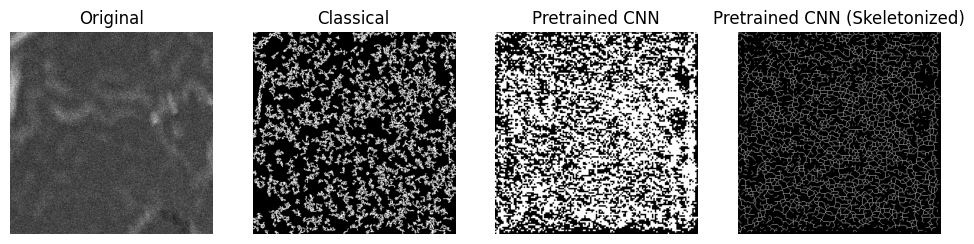

In [30]:
# @title Visualization (same as before)

plt.figure(figsize=(12,4))

plt.subplot(1,4,1)
plt.title("Original")
plt.imshow(sem_image, cmap='gray')
plt.axis("off")

plt.subplot(1,4,2)
plt.title("Classical")
plt.imshow(binary_classical, cmap='gray')
plt.axis("off")

plt.subplot(1,4,3)
plt.title("Pretrained CNN")
plt.imshow(metrics_nn_brod['mask'], cmap='gray')
plt.axis("off")

plt.subplot(1,4,4)
plt.title("Pretrained CNN (Skeletonized)")
plt.imshow(metrics_nn_crack['mask'], cmap='gray')
plt.axis("off")

plt.show()

Interation 2 with tensorflow backbone model